# Imports

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import logm

# Discrete Equations

In [7]:
def hat(v):
    return ca.vertcat(
        ca.horzcat(0, -v[2], v[1]),
        ca.horzcat(v[2], 0, -v[0]),
        ca.horzcat(-v[1], v[0], 0)
    )

def vee(S):
    return ca.vertcat(S[2, 1], S[0, 2], S[1, 0])

def expm_so3(A):
    """
    Computes exp(A) for A in so(3) using Rodrigues' rotation formula.
    """
    w = vee(A)
    
    # Compute the angle theta as the norm of w
    theta = ca.norm_2(w)

    # Identity matrix
    I = ca.DM.eye(3)
    
    eps = 1e-12
    small_theta_approx = I + A
    full_formula = ca.MX.zeros(3, 3)  # Placeholder
    
    A2 = ca.mtimes(A, A)
    
    sin_theta = ca.sin(theta)
    cos_theta = ca.cos(theta)
    
    full_formula = (
        I
        + (sin_theta / theta) * A
        + ((1.0 - cos_theta) / (theta**2)) * A2
    )
    

    weight = 0.5 * (1 + ca.tanh((theta - eps) * 1e6))
    R = (1 - weight) * small_theta_approx + weight * full_formula
    
    return R

def create_quadrotor_dynamics():
    # Parameters
    parameters = {}
    parameters["mass"] = ca.MX.sym("m", 1)  # Mass
    parameters["inertia"] = ca.MX.sym("J", 3, 3)  # Inertia matrix
    parameters["time_step"] = ca.MX.sym("h", 1)  # Time step
    parameters["wind_coeff"] = ca.MX.sym("cd", 1) # drag coeff
    parameters["wind_vel"] = ca.MX.sym("vw", 3) # wind vel.

    m = parameters["mass"]
    J = parameters["inertia"]
    h = parameters["time_step"]
    cd = parameters["wind_coeff"]
    vw = parameters["wind_vel"]

    # Constants
    g = 9.81
    e3 = ca.vertcat(0.0, 0.0, 1.0)  # b3 in body frame

    x = ca.MX.sym("x", 3)  # Position
    p = ca.MX.sym("p", 3)  # Linear momentum
    R = ca.MX.sym("R", 3, 3)  # Rotation matrix
    pi = ca.MX.sym("pi", 3)  # Angular momentum

    # Inputs (thrust force and moment)
    f = ca.MX.sym("f", 1)  # Thrust magnitude
    M = ca.MX.sym("M", 3)  # Moment vector

    # Dynamics function
    def dynamics_lgvi(x_, p_, R_, pi_):
        # Compute omega from angular momentum
        omega = ca.mtimes(ca.inv(J), pi_)

        # Compute Jd = (1/2) * trace(J) * I - J
        J_trace = ca.trace(J)
        Jd = 0.5 * J_trace * ca.MX.eye(3) - J

        f_vec = ca.MX.sym("f_vec", 3)  # Vector to solve for
        Fk = expm_so3(hat(f_vec))  # Exponential map to get rotation matrix Fk
        residual = vee(h * hat(pi_) - (ca.mtimes(Fk, Jd) - ca.mtimes(Jd, Fk.T)))
        f_vec_sol = ca.Function(
            "f_vec_sol",
            [f_vec, J, h, pi],
            [residual],
        )
        # Use a root finder to solve for f_vec
        solver = ca.rootfinder("solver", "newton", f_vec_sol, {"max_iter": 20})
        f_vec_init = ca.DM([0.005, 0.005, 0.005])  # Initial guess
        f_vec_opt = solver(f_vec_init, J, h, pi)
        Fk = expm_so3(hat(f_vec_opt))

        # State updates
        x_next = x_ + h * (p_ / m)  # Position update
        R_next = ca.mtimes(R_, Fk)  # Rotation update

        # Gravity and thrust in inertial frame
        gravity = ca.vertcat(0.0, 0.0, -g)
        p_next = p_ + h * (m * gravity + f * ca.mtimes(R_next, e3) - cd*(p_/m - vw)*ca.norm_2(p_/m - vw))  # Linear momentum update
        pi_next = ca.mtimes(Fk.T, pi_) + h * M  # Angular momentum update

        return x_next, p_next, R_next, pi_next

    # Compute next states
    x_next, p_next, R_next, pi_next = dynamics_lgvi(x, p, R, pi)

    # Create a CasADi function
    states = ca.vertcat(x, p, ca.reshape(R, 9, 1), pi)  # Flatten R to 9x1
    inputs = ca.vertcat(f, M)
    params = ca.vertcat(m, ca.reshape(J, 9, 1), h, cd, vw)  # Flatten J to 9x1
    next_states = ca.vertcat(x_next, p_next, ca.reshape(R_next, 9, 1), pi_next)

    dynamics_fn = ca.Function(
        "quadrotor_dynamics_lgvi",
        [states, inputs, params],
        [next_states],
        ["states", "inputs", "params"],
        ["next_states"]
    )

    return dynamics_fn

In [13]:
# Parameters
t = 5.0  # Total time (s)
h = 0.001  # Time step
N = int(t / h)  # Number of time steps
m = 4.34
J = ca.diag(ca.DM([0.0820, 0.0845, 0.1377]))
cd = 0.01
vw = ca.DM([4.0, 4.0, 1.0])
params = ca.vertcat(m, ca.reshape(J, 9, 1), h, cd, vw)  # Constant parameters

# Initial and desired conditions
x0 = ca.DM([0, 0, 0])
v0 = ca.DM([0, 0, 0])
R0 = ca.DM.eye(3)
w0 = ca.DM([0, 0, 0])
xd = ca.DM([1.0, 1.0, 0.0])
vd = ca.DM([0, 0, 0])
Rd = ca.DM.eye(3)
wd = ca.DM([0, 0, 0])

R0_flat = ca.reshape(R0, 9, 1)
Rd_flat = ca.reshape(Rd, 9, 1)
z_init = ca.vertcat(x0, v0, R0_flat, w0)
z_desired = ca.vertcat(xd, vd, Rd_flat, wd)

# Create dynamics function
dynamics_fn = create_quadrotor_dynamics()

# Decision variables
z = [ca.MX.sym(f"z_{k}", 18) for k in range(N + 1)]  # States
u = [ca.MX.sym(f"u_{k}", 4) for k in range(N)]       # Controls

# Objective function
J = 0
for k in range(N):
    f_k = u[k][0]
    M_k = u[k][1:4]
    J += (f_k**2 + ca.sumsqr(M_k)) * h / 2


# Constraints
g = []
g.append(z[0] - z_init)  # Initial condition
for k in range(N):
    next_z = dynamics_fn(z[k], u[k], params)
    g.append(z[k + 1] - next_z)  # Dynamics
g.append(z[N] - z_desired)  # Final condition

# Stack variables and constraints
w = ca.vertcat(*z, *u)
g_vec = ca.vertcat(*g)

nlp = {"x": w, "f": J, "g": g_vec}

# Create solver
solver = ca.nlpsol("solver", "knitro", nlp)

# Initial guess
z_guess = [z_init + (z_desired - z_init) * (k / N) for k in range(N + 1)]
u_guess = [ca.DM.zeros(4) for _ in range(N)]
w0 = ca.vertcat(*z_guess, *u_guess)

# Constraint bounds
lbg = ca.DM.zeros(g_vec.size1())
ubg = ca.DM.zeros(g_vec.size1())

res = solver(x0=w0, lbg=lbg, ubg=ubg)

# Extract solution
w_opt = res["x"]
z_opt = [w_opt[k * 18:(k + 1) * 18] for k in range(N + 1)]
u_opt = [w_opt[(N + 1) * 18 + k * 4:(N + 1) * 18 + (k + 1) * 4] for k in range(N)]


zf = z_opt[-1]  # Final state
xf = zf[0:3]    # Final position
vf = zf[3:6]    # Final velocity
Rf_flat = zf[6:15]  # Final rotation (flattened)
wf = zf[15:18]  # Final angular velocity
Rf = ca.reshape(Rf_flat, 3, 3)  # Final rotation matrix

xf = np.array(xf)
vf = np.array(vf)
Rf_flat = np.array(Rf_flat)
wf = np.array(wf)
xd = np.array(xd)
vd = np.array(vd)
Rd = np.array(Rd)
wd = np.array(wd)

Rf = Rf_flat.reshape(3, 3)

pos_residual = xf - xd
vel_residual = vf - vd
rot_residual = vee(logm(Rf.T @ Rd)) 
ang_vel_residual = wf - wd

residual = np.concatenate([pos_residual, vel_residual, rot_residual, ang_vel_residual])

residual_norm = np.linalg.norm(residual)

# Print results
print("Optimal cost:", res["f"])
print("Residual norm at final state:", residual_norm)


             Trial License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 14.2.0

Knitro presolve eliminated 0 variables and 0 constraints.

hessopt                  1
numthreads               1

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Minimize
Objective type:  general
Number of variables:                             110018 (      110018)
    bounded below only:                               0 (           0)
    bounded above only:                               0 (           0)
    bounded below and above:                          0 (           0)
    fixed:                                            0 (           0)
    free:                                        110018 (      110018)
Number of constraints:                            90036 (       90036)
    linear equalities:                                0 (           0)
    quadratic equalities:                             0 (           0)
    gen. 

In [14]:
lam_g_opt = res["lam_g"]
lambda_sym = ca.MX.sym("lambda", g_vec.size1())  
# Lagrangian: L(w, lambda) = J(w) + lambda^T * g(w)
L = J + ca.dot(lambda_sym, g_vec)

# 3) Gradient of L w.r.t. decision variables w
grad_L = ca.gradient(L, w)  # This is symbolic

# 4) Create a casadi function to evaluate grad_L
grad_L_fn = ca.Function("grad_L_fn", [w, lambda_sym], [grad_L])

# 5) Evaluate at the solution
grad_L_val = grad_L_fn(w_opt, lam_g_opt)

# Convert to numpy array
grad_L_val_np = np.array(grad_L_val.full()).flatten()
#print("Gradient of the Lagrangian at the solution:", grad_L_val_np)
print("Max absolute stationarity:", np.max(np.abs(grad_L_val_np)))


# --- Primal Feasibility ---
g_fn = ca.Function("g_fn", [w], [g_vec])

g_val = g_fn(w_opt)
g_val_np = np.array(g_val.full()).flatten()

#print("Constraint values at the solution (primal feasibility):", g_val_np)
print("Max absolute constraint violation:", np.max(np.abs(g_val_np)))

Max absolute stationarity: 3.8374730943974627e-07
Max absolute constraint violation: 1.2947511951466595e-09


# Visualization

In [15]:
# Time arrays
time_s = np.linspace(0, t, N+1)  # For states: N+1 points
h = t / N

# Extract states from z_opt
x1 = np.array([z_opt[k][0].full().flatten()[0] for k in range(N+1)])
x2 = np.array([z_opt[k][1].full().flatten()[0] for k in range(N+1)])
x3 = np.array([z_opt[k][2].full().flatten()[0] for k in range(N+1)])

v1 = np.array([z_opt[k][3].full().flatten()[0] for k in range(N+1)])
v2 = np.array([z_opt[k][4].full().flatten()[0] for k in range(N+1)])
v3 = np.array([z_opt[k][5].full().flatten()[0] for k in range(N+1)])
v1 = v1/m
v2 = v2/m
v3 = v3/m

inertia_inv = np.linalg.inv(np.diag([0.0820, 0.0845, 0.1377])) ##################
omega = np.array([
    inertia_inv @ z_opt[k][15:18].full().flatten() for k in range(N+1)
])
omega1 = omega[:, 0]
omega2 = omega[:, 1]
omega3 = omega[:, 2]

# Extract controls from u_opt (N points)
f = np.array([u_opt[k][0].full().flatten()[0] for k in range(N)])
m1 = np.array([u_opt[k][1].full().flatten()[0] for k in range(N)])
m2 = np.array([u_opt[k][2].full().flatten()[0] for k in range(N)])
m3 = np.array([u_opt[k][3].full().flatten()[0] for k in range(N)])

# Extract rotation matrices
R_flat = [z_opt[k][6:15].full().flatten() for k in range(N+1)]
R_matrices = [np.reshape(R_flat[k], (3, 3)) for k in range(N+1)]

# Compute orthogonality error: ||R^T R - I||_F
er = [np.linalg.norm(R_matrices[k].T @ R_matrices[k] - np.eye(3), 'fro') for k in range(N+1)]

# Compute attitude error: vee(log(R_k^T R_{k+1})) for k=0 to N-1
def vee_num(S):
    return np.array([S[2,1], S[0,2], S[1,0]])

era = [np.linalg.norm(vee_num(logm(R_matrices[k].T @ Rd))) for k in range(N)]

m_val = m
g_val = 9.81
inertia_diag = np.array([0.0820, 0.0845, 0.1377]) ###########################

kinetic_energy_array = []
potential_energy_array = []
total_energy_array = []

for i in range(len(time_s)):
    # Translational kinetic energy: 0.5 * m * v^2
    v = np.array([v1[i], v2[i], v3[i]])
    translational_ke = 0.5 * m_val * np.dot(v, v)
    
    # Rotational kinetic energy: 0.5 * omega^T * inertia * omega
    omega_i = np.array([omega1[i], omega2[i], omega3[i]])
    rotational_ke = 0.5 * np.dot(omega_i, np.diag(inertia_diag).dot(omega_i))
    
    kinetic_energy = translational_ke + rotational_ke
    # Potential energy: m * g * (vertical position)
    potential_energy = m_val * g_val * x3[i]
    
    total_energy = kinetic_energy + potential_energy
    
    kinetic_energy_array.append(kinetic_energy)
    potential_energy_array.append(potential_energy)
    total_energy_array.append(total_energy)

kinetic_energy_array = np.array(kinetic_energy_array)
potential_energy_array = np.array(potential_energy_array)
total_energy_array = np.array(total_energy_array)

T1 = []
T2 = []
T3 = []
T4 = []
d = 0.315
ct = 8.004e-4
matrix = np.array([[1, 1, 1, 1],
                    [0, -d, 0, d],
                    [d, 0, -d, 0],
                    [-ct, ct, -ct, ct]])
for i in range(N):
    T = np.linalg.inv(matrix) @ np.array([f[i], m1[i], m2[i], m3[i]])
    T1.append(T[0])
    T2.append(T[1])
    T3.append(T[2])
    T4.append(T[3])
T1 = np.array(T1)
T2 = np.array(T2)
T3 = np.array(T3)
T4 = np.array(T4)

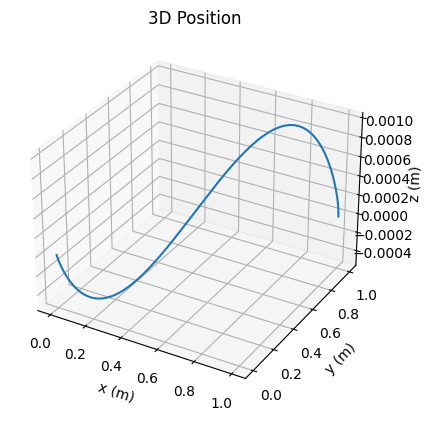

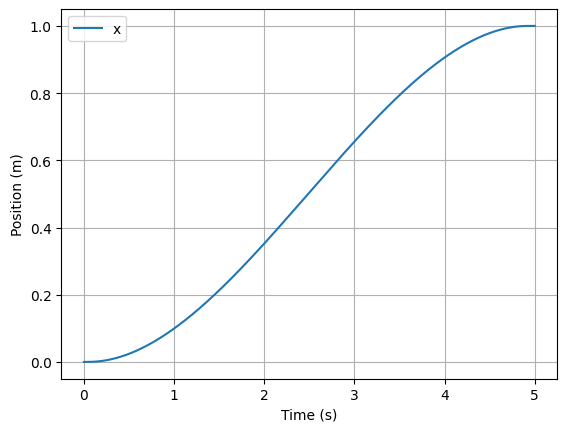

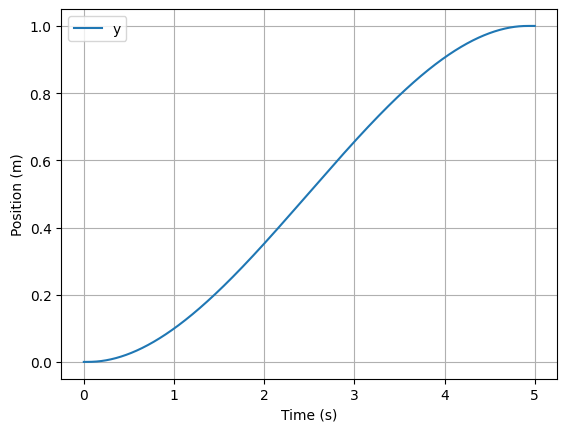

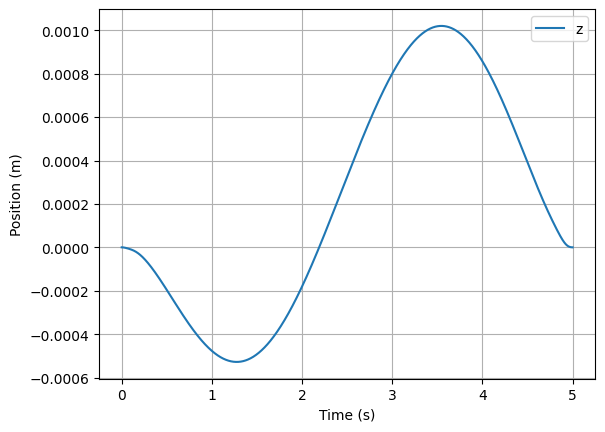

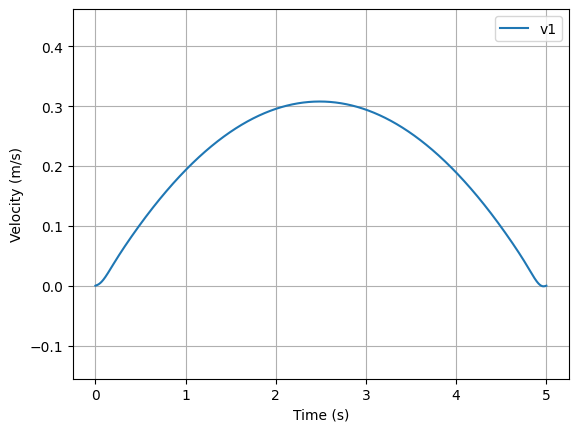

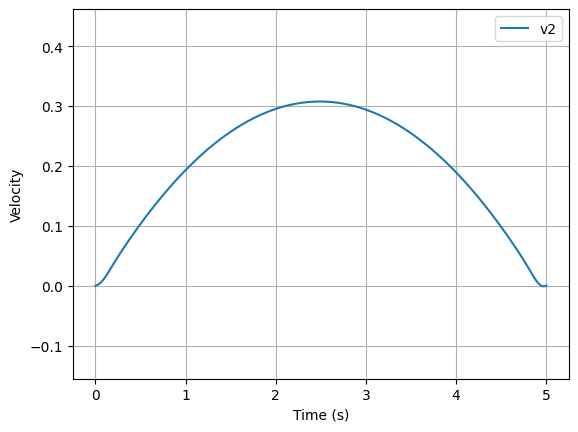

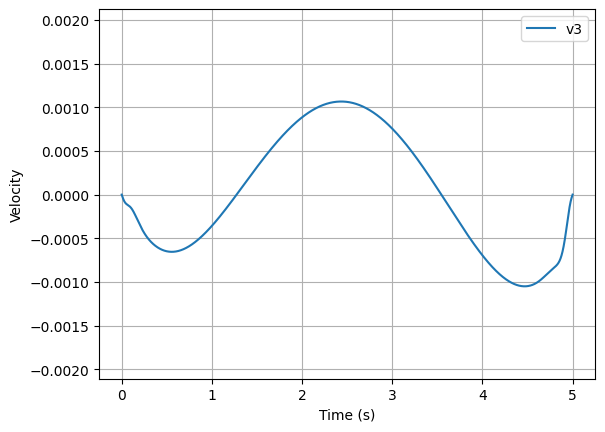

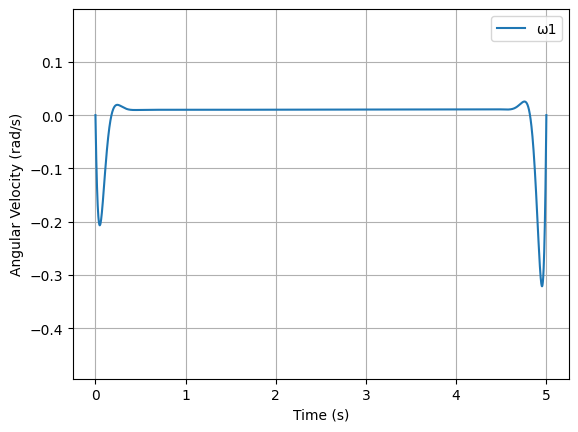

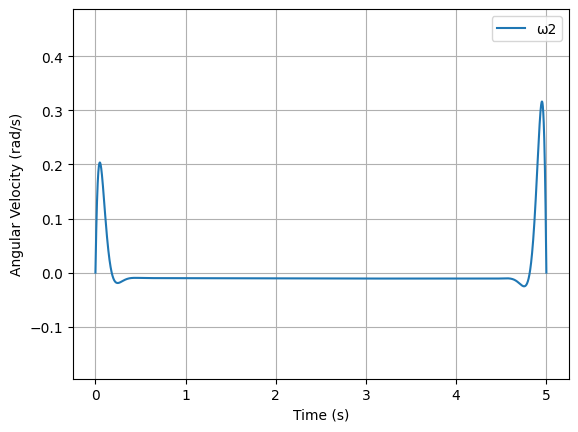

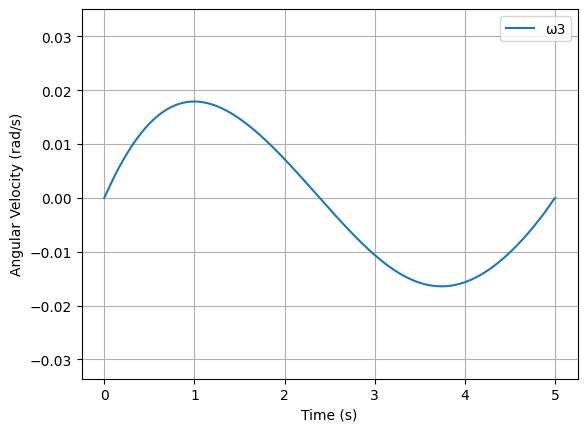

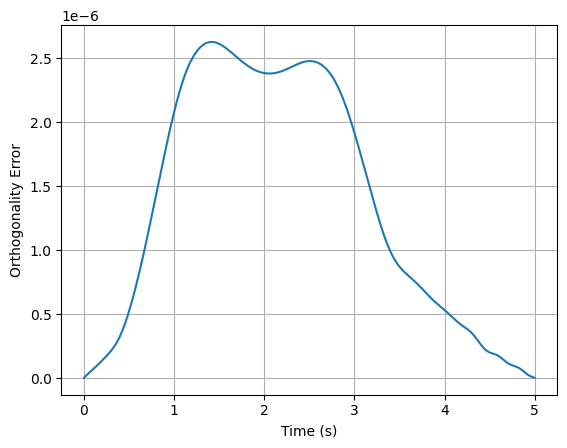

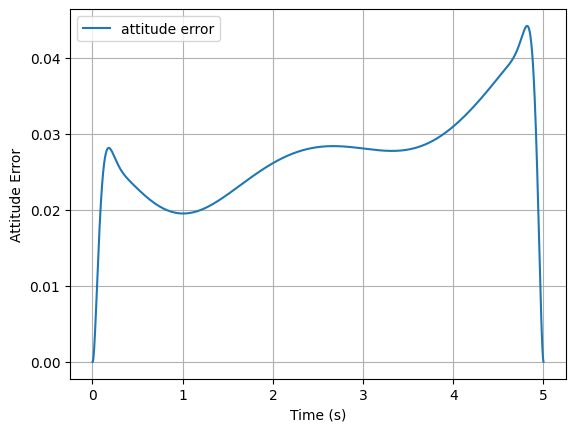

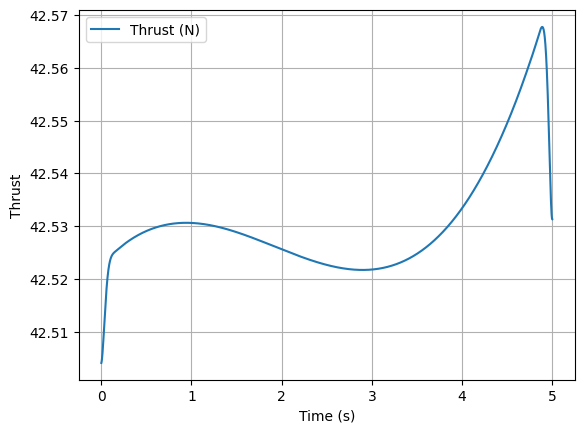

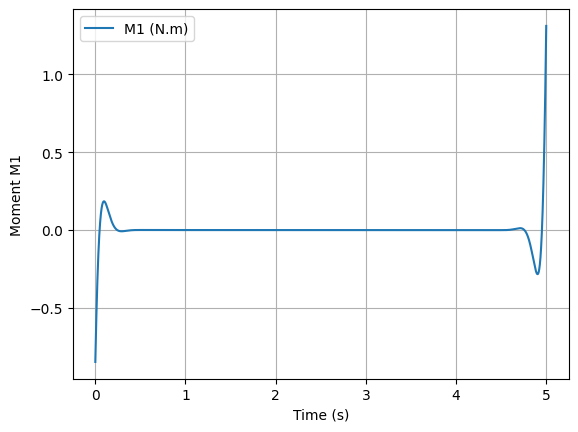

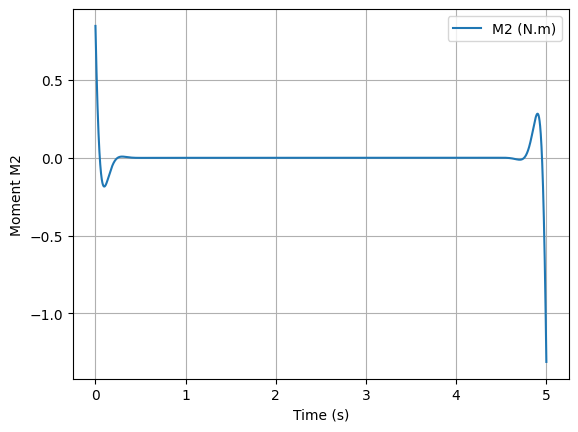

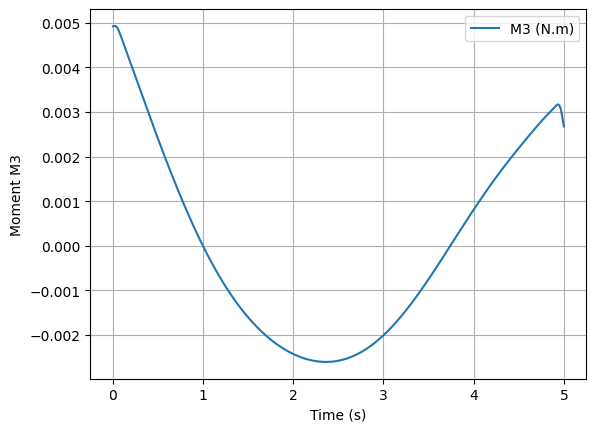

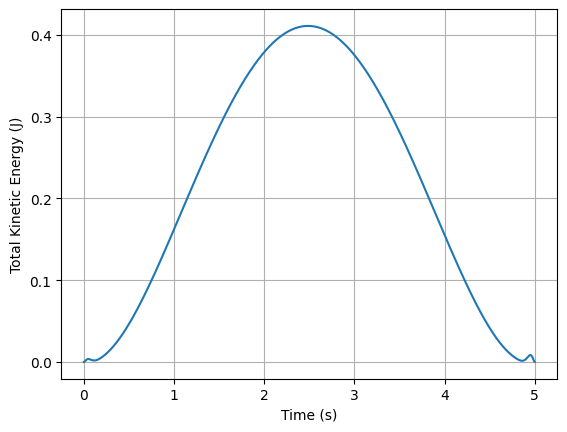

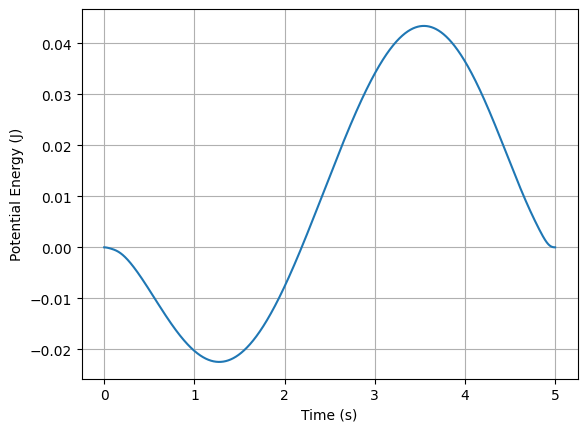

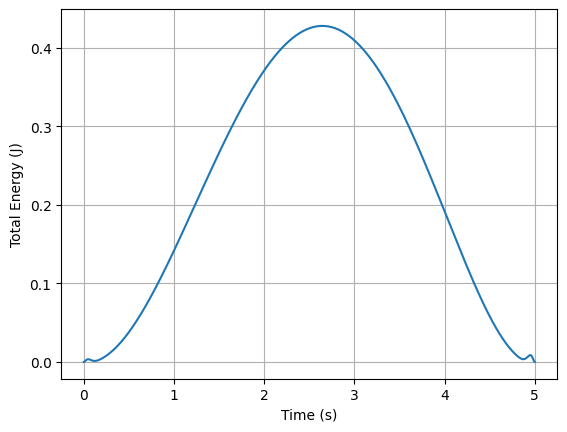

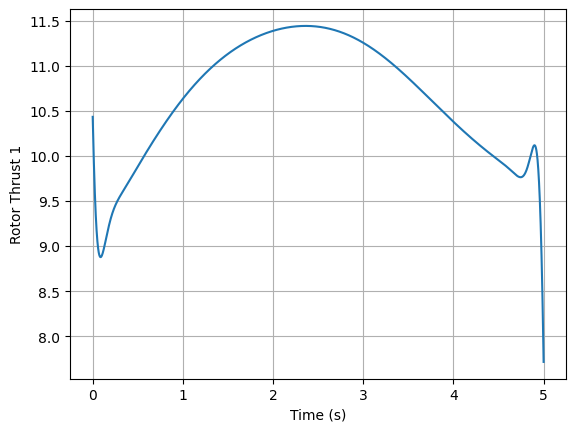

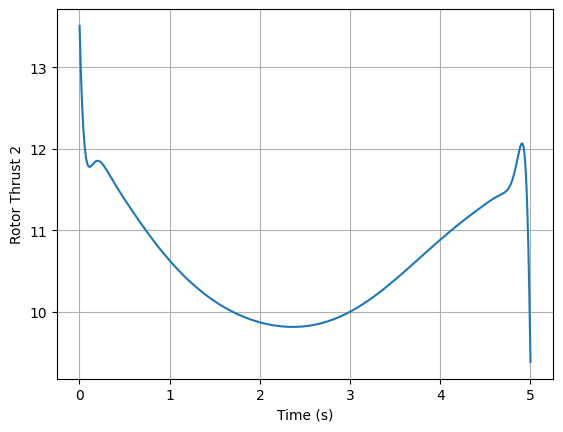

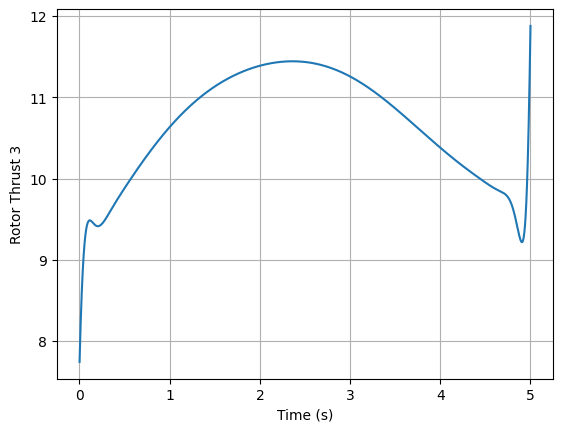

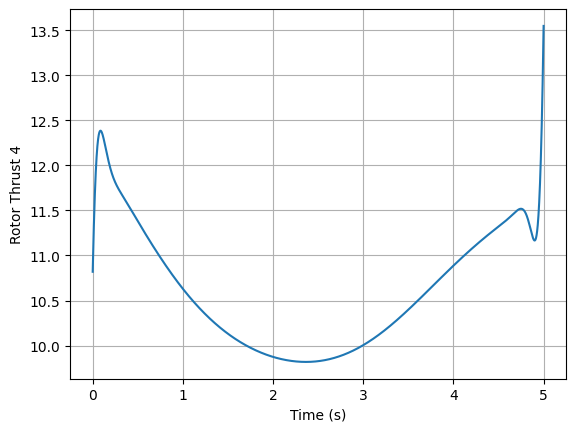

In [16]:
# Plotting
# 3D Position Trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, x2, x3)
ax.set_title("3D Position")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
plt.show()

# Position x1 vs time
plt.figure()
plt.plot(time_s, x1, label="x")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.grid()
plt.show()

# Position x2 vs time
plt.figure()
plt.plot(time_s, x2, label="y")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.grid()
plt.show()

# Position x3 vs time
plt.figure()
plt.plot(time_s, x3, label="z")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.grid()
plt.show()

# Velocity v1 vs time
plt.figure()
plt.plot(time_s, v1, label="v1")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.margins(y=0.5)
plt.grid()
plt.show()

# Velocity v2 vs time
plt.figure()
plt.plot(time_s, v2, label="v2")
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.margins(y=0.5)
plt.grid()
plt.show()

# Velocity v3 vs time
plt.figure()
plt.plot(time_s, v3, label="v3")
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.margins(y=0.5)
plt.grid()
plt.show()

# Angular velocity omega1 vs time
plt.figure()
plt.plot(time_s, omega1, label="ω1")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.margins(y=0.5)
plt.grid()
plt.show()

# Angular velocity omega2 vs time
plt.figure()
plt.plot(time_s, omega2, label="ω2")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.margins(y=0.5)
plt.grid()
plt.show()

# Angular velocity omega3 vs time
plt.figure()
plt.plot(time_s, omega3, label="ω3")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.margins(y=0.5)
plt.grid()
plt.show()

# Orthogonality error vs time
plt.figure()
plt.plot(time_s, er)
plt.xlabel("Time (s)")
plt.ylabel("Orthogonality Error")
plt.grid()
plt.show()

# Attitude error vs time (from t=h to t=t)
plt.figure()
plt.plot(time_s[1:], era, label="attitude error")
plt.xlabel("Time (s)")
plt.ylabel("Attitude Error")
plt.legend()
plt.grid()
plt.show()

# Thrust vs time (N points)
plt.figure()
plt.plot(time_s[1:], f, label="Thrust (N)")
plt.xlabel("Time (s)")
plt.ylabel("Thrust")
plt.legend()
plt.grid()
plt.show()

# Moment m1 vs time
plt.figure()
plt.plot(time_s[1:], m1, label="M1 (N.m)")
plt.xlabel("Time (s)")
plt.ylabel("Moment M1")
plt.legend()
plt.grid()
plt.show()

# Moment m2 vs time
plt.figure()
plt.plot(time_s[1:], m2, label="M2 (N.m)")
plt.xlabel("Time (s)")
plt.ylabel("Moment M2")
plt.legend()
plt.grid()
plt.show()

# Moment m3 vs time
plt.figure()
plt.plot(time_s[1:], m3, label="M3 (N.m)")
plt.xlabel("Time (s)")
plt.ylabel("Moment M3")
plt.legend()
plt.grid()
plt.show()

# --- Plot Total Energy ---
plt.figure()
plt.plot(time_s, kinetic_energy_array)
plt.xlabel("Time (s)")
plt.ylabel("Total Kinetic Energy (J)")
plt.grid()
plt.show()

plt.figure()
plt.plot(time_s, potential_energy_array)
plt.xlabel("Time (s)")
plt.ylabel("Potential Energy (J)")
plt.grid()
plt.show()

# Plot Total Energy vs Time
plt.figure()
plt.plot(time_s, total_energy_array)
plt.xlabel("Time (s)")
plt.ylabel("Total Energy (J)")
plt.grid()
plt.show()

plt.figure()
plt.plot(time_s[1:], T1)
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 1")
plt.grid()
plt.show()

plt.figure()
plt.plot(time_s[1:], T2)
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 2")
plt.grid()
plt.show()

plt.figure()
plt.plot(time_s[1:], T3)
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 3")
plt.grid()
plt.show()

plt.figure()
plt.plot(time_s[1:], T4)
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 4")
plt.grid()
plt.show()